
Classification Report:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       126
           1       1.00      1.00      1.00        74

    accuracy                           1.00       200
   macro avg       1.00      1.00      1.00       200
weighted avg       1.00      1.00      1.00       200

Confusion Matrix:


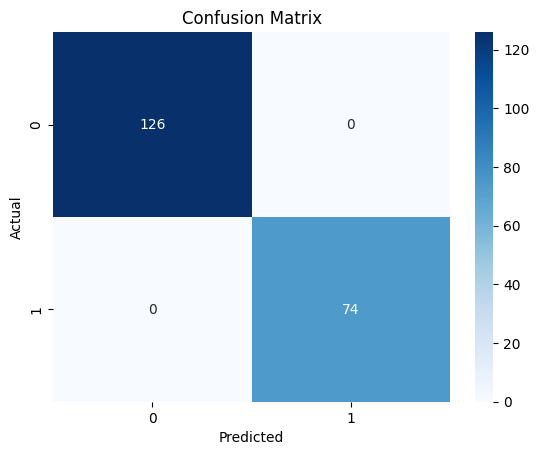

In [1]:
# Claim Delay Analysis Project in Jupyter Notebook

# 1. Import libraries
import pandas as pd
import numpy as np
import random
from faker import Faker
import datetime
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

# 2. Generate Synthetic Data
fake = Faker()
Faker.seed(42)
np.random.seed(42)

n_samples = 1000

def random_date(start, end):
    return start + datetime.timedelta(
        seconds=random.randint(0, int((end - start).total_seconds())),
    )

data = []

for _ in range(n_samples):
    admit_date = fake.date_between(start_date='-2y', end_date='-1y')
    discharge_date = admit_date + datetime.timedelta(days=random.randint(1, 10))
    entry_date = discharge_date + datetime.timedelta(days=random.randint(1, 15))
    update_date = entry_date + datetime.timedelta(days=random.randint(1, 15))

    trans_amount = round(random.uniform(1000, 10000), 2)
    pay_amount = round(trans_amount * random.uniform(0.4, 0.9), 2)

    delay = (update_date - entry_date).days > 10  # Label for IsDelayed

    notes = fake.sentence(nb_words=12) + (" missing documents" if delay else " all documents present")

    data.append({
        "AccountNumber": fake.uuid4(),
        "VisitID": fake.uuid4(),
        "AdmitDate": admit_date,
        "DischargeDate": discharge_date,
        "Name": fake.name(),
        "PatientID": fake.uuid4(),
        "LocationID": fake.random_int(1, 5),
        "AccountType": random.choice(["Inpatient", "Outpatient"]),
        "CurrentPrimaryInsurance": random.choice(["Insurer A", "Insurer B", "Insurer C"]),
        "CurrentFinancialClass": random.choice(["Private", "Govt", "Self-pay"]),
        "EntryBy": fake.name(),
        "EntryDate": entry_date,
        "DS_YEAR": discharge_date.year,
        "DS_MONTH": discharge_date.month,
        "DS_DAY": discharge_date.day,
        "DS_WD": discharge_date.weekday(),
        "Notes": notes,
        "TransCount": random.randint(1, 5),
        "TransAmount": trans_amount,
        "TransactionInsurance": random.choice(["Yes", "No"]),
        "PSTAmount": round(trans_amount * 0.1, 2),
        "ADJAmount": round(trans_amount * 0.05, 2),
        "PAYAmount": pay_amount,
        "REVAmount": round(trans_amount - pay_amount, 2),
        "BillNo": fake.uuid4(),
        "BillStatus": random.choice(["Submitted", "Pending", "Paid"]),
        "BillType": random.choice(["Type A", "Type B", "Type C"]),
        "BillFromDate": admit_date,
        "BillThroughDate": discharge_date,
        "Reference1": fake.uuid4(),
        "Reference2": fake.uuid4(),
        "ClaimID": fake.uuid4(),
        "RMCCode": fake.random_element(elements=("A01", "B02", "C03")),
        "ClaimGroupCode": random.choice(["Group 1", "Group 2"]),
        "ClaimDeptResponsible": random.choice(["Cardiology", "Radiology", "Billing"]),
        "UpdateDateTime": update_date,
        "IsDelayed": int(delay)
    })

# Convert to DataFrame
df = pd.DataFrame(data)

# 3. Feature Engineering
features = [
    "AccountType", "CurrentPrimaryInsurance", "CurrentFinancialClass",
    "TransactionInsurance", "BillType", "ClaimDeptResponsible",
    "TransAmount", "PAYAmount", "REVAmount", "Notes"
]

X = df[features]
y = df["IsDelayed"]

# 4. Build ML Pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), ["TransAmount", "PAYAmount", "REVAmount"]),
        ("cat", OneHotEncoder(handle_unknown="ignore"), [
            "AccountType", "CurrentPrimaryInsurance", "CurrentFinancialClass",
            "TransactionInsurance", "BillType", "ClaimDeptResponsible"
        ]),
        ("txt", TfidfVectorizer(max_features=50), "Notes")
    ]
)

pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("classifier", RandomForestClassifier(n_estimators=100, random_state=42))
])

# 5. Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 6. Train Model
pipeline.fit(X_train, y_train)

# 7. Evaluate Model
y_pred = pipeline.predict(X_test)
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:")
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()
